In [1]:
#%matplotlib inline
import tensorflow as tf
import numpy as np
#import matplotlib.pyplot as plt
from siamese.dataset import Dataset
from siamese.dataset import DataLoader
from siamese.model import *

from scipy.spatial.distance import cdist
from matplotlib import gridspec

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from functools import reduce

In [2]:
loader = DataLoader('../../data/',['t2tsetra/t/40x40x1/'])
loader.load_data()
X,y = loader.get_data('t2tsetra/t/40x40x1/')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [2]:
(X_train,y_train),(X_test,y_test) = tf.keras.datasets.fashion_mnist.load_data()
X_train = X_train.reshape(-1,28,28,1)
X_test = X_test.reshape(-1,28,28,1)
X_train = X_train / 255
X_test = X_test / 255


In [3]:
dataset = Dataset()

In [4]:
dataset.images_train = X_train[:10000]
dataset.images_test = X_test
dataset.labels_train = y_train
dataset.labels_test = y_test


In [5]:
#helper function to plot image
def show_image(idxs, data):
    if type(idxs) != np.ndarray:
        idxs = np.array([idxs])
    fig = plt.figure(figsize = (18,10))
    gs = gridspec.GridSpec(1,len(idxs))
    for i in range(len(idxs)):
        ax = fig.add_subplot(gs[0,i])
        ax.imshow(data[idxs[i],:,:,0],cmap = 'gray')
        ax.axis('off')
    plt.show()

## Create the siamese net feature extraction model

In [6]:
img_placeholder = tf.placeholder(tf.float32, [None] + list(dataset.images_train.shape[1:]), name='img')
net = mnist_model(img_placeholder, reuse=False)

## Restore from checkpoint and calc the features from all of train data

In [7]:
#run the train image through the network to get the test features
saver = tf.train.Saver()
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    ckpt = tf.train.get_checkpoint_state("model")
    saver.restore(sess, "model/model.ckpt")
    train_feat = sess.run(net, feed_dict={img_placeholder:dataset.images_train})

INFO:tensorflow:Restoring parameters from model/model.ckpt


In [8]:
#run the test image through the network to get the test features
saver = tf.train.Saver()
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    ckpt = tf.train.get_checkpoint_state("model")
    saver.restore(sess, "model/model.ckpt")
    search_feat = sess.run(net, feed_dict={img_placeholder:dataset.images_test})
    

INFO:tensorflow:Restoring parameters from model/model.ckpt


## Count similarity

In [12]:
y_pred = []
for idx,feat in enumerate(search_feat):
    #calculate the cosine similarity and sort
    y_pred.append(siamese_accuracy(train_feat,feat,dataset))
    

In [13]:
accuracy_score(dataset.labels_test,y_pred)

0.7592592592592593

In [14]:
search_feat[0]

array([ 0.32553238, -0.11568847], dtype=float32)

In [15]:
dataset.labels_train[rank[:10]]

NameError: name 'rank' is not defined

In [29]:
import operator
stats = {'a':1000, 'b':3000, 'c': 100, 'd':3000}
max(stats.items(), key=operator.itemgetter(1))[0]

'b'

In [10]:
def siamese_accuracy(train_feat, search_feat, dataset):
    n = 10
    dist = cdist(train_feat, [feat], 'cosine')
    rank = np.argsort(dist.ravel())
    
    labels = dataset.labels_train[rank[:n]]
    c = Counter(labels) 
    dictionary = dict([(i, c[i] / len(labels) * 100.0) for i in c])
    a = max(dictionary.items(), key=operator.itemgetter(1))[0]
    b = labels[0]
    return a
    

In [11]:
from collections import Counter
import operator

In [14]:
from sklearn.ensemble import RandomForestClassifier

In [19]:
rf = RandomForestClassifier()

In [20]:
rf = rf.fit(train_feat,dataset.labels_train)

/home/frantisek/anaconda3/envs/tf-gpu/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [21]:
pred = rf.predict(search_feat)

In [22]:
accuracy_score(dataset.labels_test,pred)

0.7592592592592593

In [25]:
from sklearn.metrics import classification_report

In [27]:
a = classification_report(dataset.labels_test,pred)

In [32]:
print(a)

              precision    recall  f1-score   support

           0       0.80      0.92      0.86        85
           1       0.36      0.17      0.24        23

   micro avg       0.76      0.76      0.76       108
   macro avg       0.58      0.55      0.55       108
weighted avg       0.71      0.76      0.72       108



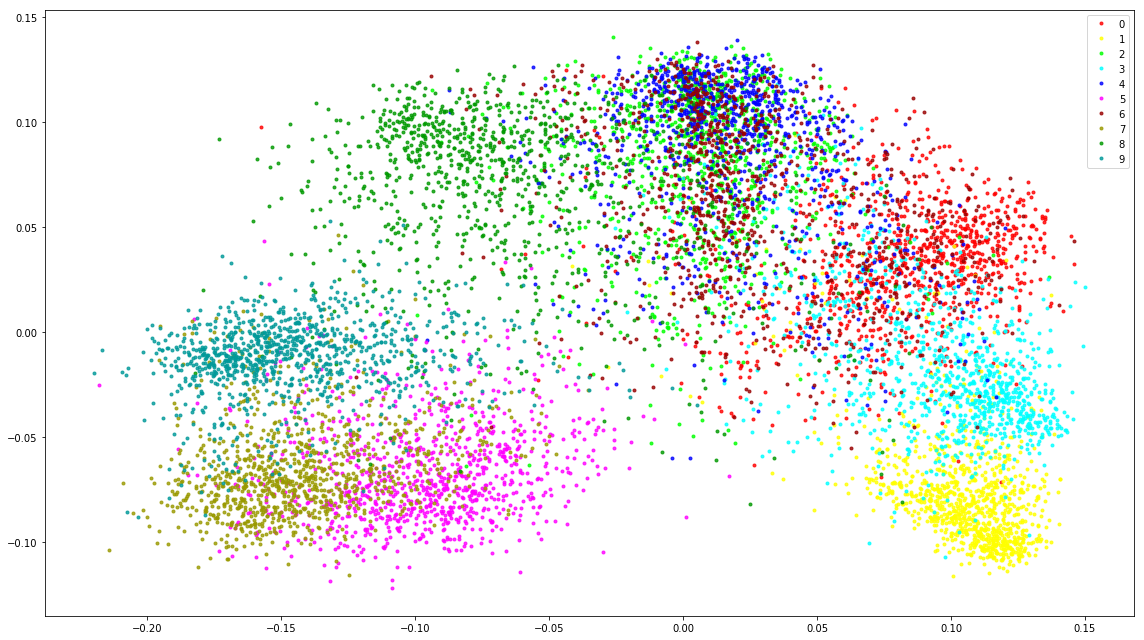

In [60]:
colors = ['#ff0000', '#ffff00', '#00ff00', '#00ffff', '#0000ff', '#ff00ff', '#990000', '#999900', '#009900', '#009999']
feat = train_feat
labels = dataset.labels_train[:10000]
# plot result
f = plt.figure(figsize=(16,9))
f.set_tight_layout(True)
for j in range(10):
    plt.plot(feat[labels==j, 0].flatten(), feat[labels==j, 1].flatten(), '.', c=colors[j], alpha=0.8)
    plt.legend(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'])
   